# 18MA20015 | Harshal Dupare
http://www.vision.caltech.edu/Image_Datasets/Caltech101/#Download

Above is the CalTech101 dataset, where there are 50-200 images belonging to 101 different objects, along with annotations, which indicate the precise locations of the objects inside each image (box_coord). Use Image.crop function to select only the part of each image that contains the object. Reduce the images to 50 x 50 size. 

Use 10 categories only (accordion, airplanes, bass, bonsai, brain, buddha, butterfly, camera, cannon, car_side) for this assignment. In each of the 10 categories,choose the first 40 images for training, and the next 10 for testing.

Train 10 neural network classifiers to carry out one-vs-all classification for each of the 10 classes. Each neural network will have only one intermediate layer, with half the number of input nodes, i.e. (50*50)/2=1250. The output layer will have one node- the probability of "yes" for the class. Use sigmoid activation function in both layers and squared error loss function for the output layer. Train the 10 neural networks using the training images by turning their class-labels into binary (1/0) probability of each class. 

Take each test image, apply it to all 10 classifiers, and obtain the "yes" probabilities of the 10 classes. Its predicted label is the class for which the "yes" probability is highest. Report the accuracy.

Compare this with a convolutional neural network for multi-class classification. Use any libraries and CNN architecture of your choice.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix
import copy 
import seaborn as sn
import torch
import torch.nn as nn
import torch.functional as F
import cv2
from torchvision import transforms
from torch import nn, optim
from tqdm.notebook import tqdm
import os
import scipy.io as sio

In [2]:
DataFold = os.path.join("drive","MyDrive","DL","101_ObjectCategories")
AnnotFold = os.path.join("drive","MyDrive","DL","Annotations") 
ImagesPath = ["accordion", "airplanes", "bass", "bonsai", "brain", "buddha", "butterfly", "camera", "cannon", "car_side"]
AnnotsPath = ["accordion", "Airplanes_Side_2", "bass", "bonsai", "brain", "buddha", "butterfly", "camera", "cannon", "car_side"]

In [3]:
# loads image as gray scale image
# reshapes it and returns as a np.array

def image_to_vec(ipath,apath):
    img = cv2.imread(ipath,0)
    anno = sio.loadmat(apath)
    x1,x2,y1,y2 = anno['box_coord'][0]
    img = cv2.resize(img[x1:x2+1,y1:y2+1], (50,50), interpolation = cv2.INTER_AREA)
    return img.reshape([1,-1])[0]


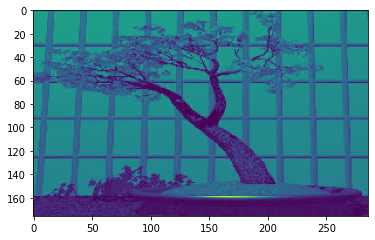

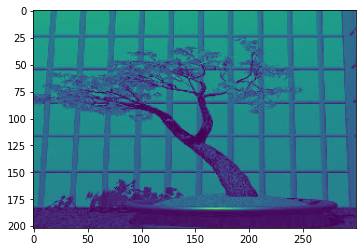

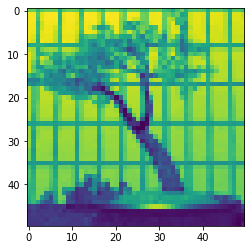

In [4]:
# example of cropping and resizing 
apath = os.path.join(AnnotFold,AnnotsPath[3],"annotation_"+str(8).zfill(4)+".mat")
ipath = os.path.join(DataFold,ImagesPath[3],"image_"+str(8).zfill(4)+".jpg")
img = cv2.imread(ipath,0)
anno = sio.loadmat(apath)
x1,x2,y1,y2 = anno['box_coord'][0]
plt.imshow(img[x1:x2+1,y1:y2+1])
plt.show()
plt.imshow(img)
plt.show()
rimg = cv2.resize(img[x1:x2+1,y1:y2+1], (50,50), interpolation = cv2.INTER_AREA)
plt.imshow(rimg)
plt.show()

In [5]:
# loading data

X_train,y_train,X_test,y_test = [],[],[],[]
na_paths = []
for ict in tqdm(range(10)):
  for i in range(1,51):
    apath = os.path.join(AnnotFold,AnnotsPath[ict],"annotation_"+str(i).zfill(4)+".mat")
    ipath = os.path.join(DataFold,ImagesPath[ict],"image_"+str(i).zfill(4)+".jpg")
    try:
      if i < 41:
        X_train.append(image_to_vec(ipath,apath))
        y_train.append(ict)
      else:
        X_test.append(image_to_vec(ipath,apath))
        y_test.append(ict)
    except:
      na_paths.append(ipath)


In [6]:
na_paths

['drive/MyDrive/DL/101_ObjectCategories/cannon/image_0044.jpg',
 'drive/MyDrive/DL/101_ObjectCategories/cannon/image_0045.jpg',
 'drive/MyDrive/DL/101_ObjectCategories/cannon/image_0046.jpg',
 'drive/MyDrive/DL/101_ObjectCategories/cannon/image_0047.jpg',
 'drive/MyDrive/DL/101_ObjectCategories/cannon/image_0048.jpg',
 'drive/MyDrive/DL/101_ObjectCategories/cannon/image_0049.jpg',
 'drive/MyDrive/DL/101_ObjectCategories/cannon/image_0050.jpg']

In [7]:
cX_train,cy_train,cX_test,cy_test = np.array(X_train).astype(np.float32),np.array(y_train).astype(np.float32).reshape([-1,1]),np.array(X_test).astype(np.float32),np.array(y_test).astype(np.float32).reshape([-1,1])
cX_train,cy_train,cX_test,cy_test = torch.tensor(cX_train),torch.tensor(cy_train),torch.tensor(cX_test),torch.tensor(cy_test)
print(cX_train.shape,cy_train.shape,cX_test.shape,cy_test.shape)

torch.Size([400, 2500]) torch.Size([400, 1]) torch.Size([93, 2500]) torch.Size([93, 1])


In [23]:
print_training = False

class NN(nn.Module):
    def __init__(self):
      super(NN,self).__init__()
      # fully connected layers
      self.fcon1 = nn.Linear(50*50,50*25)
      self.fcon2 = nn.Linear(50*25,1)
      self.sigmoid = nn.Sigmoid()
      self.relu = nn.ReLU()
        
    def forward(self,x):
      x = self.fcon1(x)
      x = self.relu(x)
      x = self.fcon2(x)
      x = self.sigmoid(x)
      return x

    def set_training(self,epochs,criterion,lrate,optimizer):
      self.n_epoch = epochs
      self.criterion = criterion
      self.using_gpu = torch.cuda.is_available()

      if self.using_gpu:
          self = self.cuda()
          self.criterion = self.criterion.cuda()

      self.learning_rate = lrate
      self.optimizer = optimizer(self.parameters(),lr=self.learning_rate)

    def fit(self,X_t,y_t):
      train_loss = []
      train_acc = []
      for epoch in range(self.n_epoch):
        self.optimizer.zero_grad()
        if self.using_gpu:
            X_t,y_t=X_t.cuda(),y_t.cuda()
  
        y_t_pred=self(X_t)

        epoch_loss = self.criterion(y_t_pred,y_t)
        
        correct_count=torch.sum(y_t==y_t_pred)
        sample_count=len(y_t_pred)
        epoch_loss = epoch_loss/len(y_t_pred)
        epoch_loss.backward()
        self.optimizer.step()
        
        train_loss.append(epoch_loss.item())
        train_acc.append(correct_count.item()/sample_count)
        if print_training:
          print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,self.n_epoch,epoch_loss,(correct_count.item()/sample_count)*100))

# note y_train must have classes numbered from [0....n-1] for n classes
class OneVsAllClassifier(object):
    def __init__(self,_n,_BinaryClassifier,_X_train,_y_train,epochs,criterion,lrate,optimizer,**kwargs):
        self.n = _n
        self.BinaryClassifier = _BinaryClassifier
        self.base_X_train = _X_train
        self.base_y_train = _y_train
        self.one_vs_all_model = {}
        for i in range(self.n):
            self.one_vs_all_model[i] = (self.BinaryClassifier(**kwargs))
            self.one_vs_all_model[i].set_training(epochs,criterion,lrate,optimizer)
        
    def fit(self):
        for i in range(self.n):
            cX_t = self.base_X_train
            cy_t = copy.deepcopy(self.base_y_train) - i + 1
            cy_t[cy_t!=1] = 0

            bx_mask = cy_t==1
            x_mask = cy_t==1
            for _ in range(cX_t.shape[1]-1):
              x_mask = torch.cat([x_mask,bx_mask],dim=1)

            cX_t = (cX_t[x_mask]).reshape([-1,2500])
            cy_t = (cy_t[cy_t==1]).reshape([-1,1])
            self.one_vs_all_model[i].fit(cX_t,cy_t)
                
    def predict(self,Xp):
        class_vote = np.zeros((Xp.shape[0],self.n))
        if self.one_vs_all_model[0].using_gpu:
            Xp=Xp.cuda()
        for i in range(self.n):
            yp=self.one_vs_all_model[i](Xp).cpu().detach().numpy()
            # if it has positive vote for the class then assign it that 
            for k in range(yp.shape[0]):
                if yp[k] > 0.5:
                    class_vote[k][i]=yp[k]
        
        # return argmax of probabilities ( scores )
        return np.argmax(class_vote,axis=1)

In [24]:
model = NN()
criterion = nn.MSELoss()
learning_rate = 1e-1
model.set_training(30,criterion,learning_rate,optim.Adam)

cy_t = copy.deepcopy(cy_train)
cX_t = copy.deepcopy(cX_train)
cy_t[cy_t!=1]=0

bx_mask = cy_t==1
x_mask = cy_t==1
for _ in range(cX_t.shape[1]-1):
  x_mask = torch.cat([x_mask,bx_mask],dim=1)

mcX_t = (cX_t[x_mask]).reshape([-1,2500])
mcy_t = (cy_t[cy_t==1]).reshape([-1,1])
for ei in range(8):
  cX_t = torch.cat([cX_t, copy.deepcopy(mcX_t)], dim=0)
  cy_t = torch.cat([cy_t, copy.deepcopy(mcy_t)], dim=0)

model.fit(cX_t,cy_t)
cy_p=model(cX_t.cuda())

print(classification_report(cy_t.detach().numpy(),cy_p.cpu().detach().numpy()))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       360
         1.0       0.00      0.00      0.00       360

    accuracy                           0.50       720
   macro avg       0.25      0.50      0.33       720
weighted avg       0.25      0.50      0.33       720



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
ova = OneVsAllClassifier(10,NN,cX_train,cy_train,10,criterion,learning_rate,optim.Adam)

In [26]:
ova.fit()

In [28]:
cy_pred = ova.predict(cX_test)

In [29]:
print(classification_report(cy_test,cy_pred))

              precision    recall  f1-score   support

         0.0       0.11      1.00      0.19        10
         1.0       0.00      0.00      0.00        10
         2.0       0.00      0.00      0.00        10
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00        10
         5.0       0.00      0.00      0.00        10
         6.0       0.00      0.00      0.00        10
         7.0       0.00      0.00      0.00        10
         8.0       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00        10

    accuracy                           0.11        93
   macro avg       0.01      0.10      0.02        93
weighted avg       0.01      0.11      0.02        93



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LeNet model

In [30]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        
        self.conv1 = nn.Conv2d(1,6,5)
        self.maxpool1 = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(6,16,5)
        
        self.fcon1 = nn.Linear(16*9*9,120)
        self.fcon2 = nn.Linear(120,84)
        self.fcon3 = nn.Linear(84,10)
        
        self.relu = nn.ReLU()
        self.relu = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        
        x = self.conv1(x)      # [6,(50-5)/1+1,(50-5)/1+1] = [6,46,46]
        x = self.relu(x)
        x = self.maxpool1(x)   # [6,(46-2)/2+1,(46-2)/2+1] = [6,23,23]
        
        x = self.conv2(x)      # [16,(23-5)/1+1,(23-5)/1+1] = [16,19,19]
        x = self.relu(x)
        x = self.maxpool1(x)   # [16,(19-2)/2+1,(19-2)/2+1] = [16,9,9]
        
        x = x.view(-1,16*9*9)
        x = self.fcon1(x)
        x = self.relu(x)
        x = self.fcon2(x)
        x = self.relu(x)
        x = self.fcon3(x)
        
        # probs
        x = self.softmax(x)
        return x

In [60]:
# loads image as gray scale image

def image_to_vec(ipath,apath):
    img = cv2.imread(ipath,0)
    anno = sio.loadmat(apath)
    x1,x2,y1,y2 = anno['box_coord'][0]
    img = cv2.resize(img[x1:x2+1,y1:y2+1], (50,50), interpolation = cv2.INTER_AREA)
    return torch.tensor(np.array(img).astype(np.float32)).reshape([1,1,50,50])

In [61]:
# loading data

X_train,y_train,X_test,y_test = [],[],[],[]
na_paths = []
for ict in tqdm(range(10)):
  for i in range(1,51):
    apath = os.path.join(AnnotFold,AnnotsPath[ict],"annotation_"+str(i).zfill(4)+".mat")
    ipath = os.path.join(DataFold,ImagesPath[ict],"image_"+str(i).zfill(4)+".jpg")
    try:
      if i < 41:
        X_train.append(image_to_vec(ipath,apath))
        y_train.append(ict)
      else:
        X_test.append(image_to_vec(ipath,apath))
        y_test.append(ict)
    except:
      na_paths.append(ipath)

In [62]:
cX_train,cy_train,cX_test,cy_test = torch.cat(X_train),torch.tensor(y_train),torch.cat(X_test),torch.tensor(y_test)

In [65]:
class Pipeline:
  def __init__(self,Model):
    self.model = Model()
    self.LR_decay = False
    self.lr_from = 1e-1
    self.lr_to = 1e-3

  def train(self,Criterion,Optimizer,N_epoch=50,print_epoch_details=True):
    # training the model

    if self.LR_decay:
      lr_decay_step = (self.lr_from - self.lr_to)/(N_epoch)
    else:
      lr_decay_step = 0.0

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in tqdm(range(N_epoch)):
        epoch_loss = 0.0
        correct_count = 0
        sample_count = 0
        Optimizer.zero_grad()
        # on Traning Data

        if using_gpu:
            X_i,y_i=cX_train.cuda(),cy_train.cuda()
        
        output=self.model(X_i)
        
        y_i_pred = torch.argmax(output,dim=1)
        
        loss = Criterion(output,y_i)
        
        epoch_loss+=loss
        
        correct_count +=torch.sum(y_i==y_i_pred)
        sample_count+=len(y_i)

        tepoch_loss = 0.0
        tcorrect_count = 0
        tsample_count = 0
        
 
        if using_gpu:
            tX_i,ty_i=cX_test.cuda(),cy_test.cuda()
        
        toutput=self.model(tX_i)
        
        ty_i_pred = torch.argmax(toutput,dim=1)

        tloss = Criterion(toutput,ty_i)
        
        tepoch_loss+=tloss
        
        tcorrect_count +=torch.sum(ty_i==ty_i_pred)
        tsample_count+=len(ty_i)

        epoch_loss=epoch_loss/(sample_count)
        tepoch_loss=tepoch_loss/(tsample_count)
        
        epoch_loss.backward()
        
        Optimizer.step()
        
        if self.LR_decay:
          for param_group in Optimizer.param_groups:
            param_group['lr'] = param_group['lr']-lr_decay_step
        
        train_loss.append(epoch_loss.item())
        train_acc.append(100*correct_count.item()/sample_count)
        test_loss.append(tepoch_loss.item())
        test_acc.append(100*tcorrect_count.item()/tsample_count)
        if print_epoch_details:
          print(f'Epoch {epoch+1:.0f}/{N_epoch:.0f} : Training loss: {train_loss[-1]:.4f} | Training Accuracy: {train_acc[-1]:.2f} | Testing loss: {test_loss[-1]:.4f} | Testing Accuracy: {test_acc[-1]:.2f} ')
    
    fig = plt.figure(figsize=[20,8]) 
    plt.subplot(121)
    plt.plot(range(N_epoch),train_loss,'g-',label='Training Loss') 
    plt.plot(range(N_epoch),test_loss,'r-',label='Testing Loss') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(122)
    plt.plot(range(N_epoch),train_acc,'g-',label='Training Accuracy') 
    plt.plot(range(N_epoch),test_acc,'r-',label='Testing Accuracy') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    optimizer_details = str(Optimizer.load_state_dict).replace("\n",",")[43:-1]


Training using GPU: True


Epoch 1/50 : Training loss: 0.0058 | Training Accuracy: 10.50 | Testing loss: 0.0248 | Testing Accuracy: 3.23 
Epoch 2/50 : Training loss: 0.0057 | Training Accuracy: 20.75 | Testing loss: 0.0247 | Testing Accuracy: 20.43 
Epoch 3/50 : Training loss: 0.0057 | Training Accuracy: 27.25 | Testing loss: 0.0246 | Testing Accuracy: 26.88 
Epoch 4/50 : Training loss: 0.0057 | Training Accuracy: 29.50 | Testing loss: 0.0245 | Testing Accuracy: 27.96 
Epoch 5/50 : Training loss: 0.0056 | Training Accuracy: 32.75 | Testing loss: 0.0244 | Testing Accuracy: 33.33 
Epoch 6/50 : Training loss: 0.0056 | Training Accuracy: 35.25 | Testing loss: 0.0242 | Testing Accuracy: 38.71 
Epoch 7/50 : Training loss: 0.0056 | Training Accuracy: 39.25 | Testing loss: 0.0240 | Testing Accuracy: 40.86 
Epoch 8/50 : Training loss: 0.0055 | Training Accuracy: 40.75 | Testing loss: 0.0238 | Testing Accuracy: 38.71 
Epoch 9/50 : Training loss: 0.0055 | Training Accuracy: 42.00 | Testing loss: 0.0236 | Testing Accuracy: 

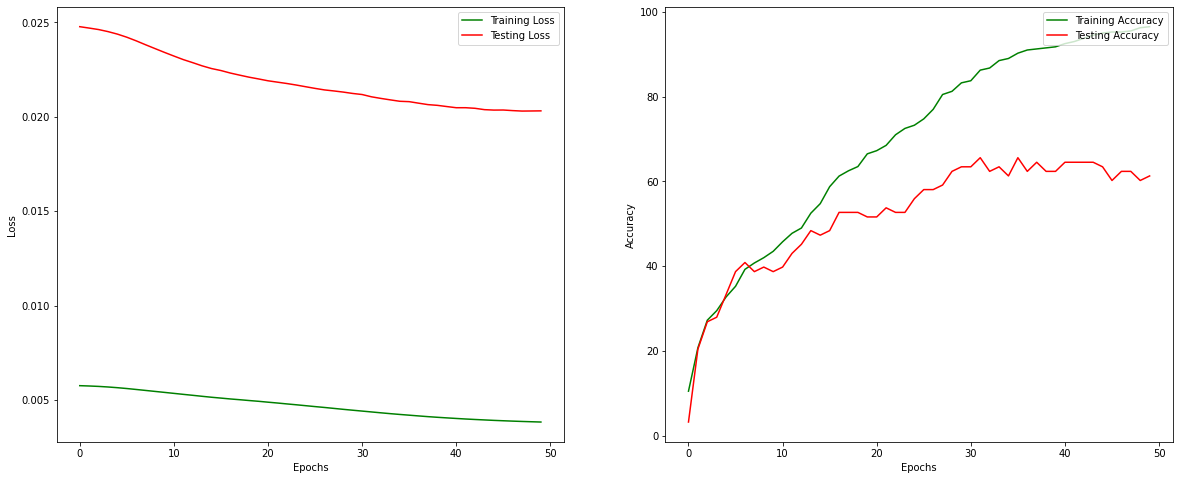

In [68]:
learning_rate = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
pl = Pipeline(LeNet)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train(criterion,optimizer_adam,n_epoch)